In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from datetime import datetime, timedelta
import numpy as np
sns.set()

# Downloading data and parse it into `Pandas DataFrame`
Credit: [https://www.ontario.ca/page/motor-fuel-prices](https://www.ontario.ca/page/motor-fuel-prices)

In [8]:
df = pd.read_csv(r'https://ontario.ca/v1/files/fuel-prices/fueltypesall.csv')

# parsing date time
df = df[df['Fuel Type'] == 'Regular Unleaded Gasoline']
df['Date'] = pd.to_datetime(df.Date, format='%Y-%m-%d')

# There are duplicates in data Date for different types (i.e. regular gas, premium gas, etc), so take only the first row up until the most recent monday for regular gas

# getting the most recent Monday
# credit: https://stackoverflow.com/questions/59981999/find-monday-of-current-week-in-python
# now = datetime.now()
# monday = now - timedelta(days = now.weekday())
# # print(monday)
# monday_idx = min((df[df.Date == str(monday.date())]).index)
# df = df.iloc[:monday_idx+1] 

In [9]:
# checking that all the gas is regular type
all(df['Fuel Type'] == 'Regular Unleaded Gasoline')

True

In [10]:
df.tail(5)

,Date,Ottawa,Toronto West/Ouest,Toronto East/Est,Windsor,London,Peterborough,St. Catharine's,Sudbury,Sault Saint Marie,Thunder Bay,North Bay,Timmins,Kenora,Parry Sound,Ontario Average/Moyenne provinciale,Southern Average/Moyenne du sud de l'Ontario,Northern Average/Moyenne du nord de l'Ontario,Fuel Type,Type de carburant
1650,2021-08-16,135.8,138.4,138.1,137.5,137.6,130.2,136.2,141.8,144.9,147.3,138.3,142.1,141.9,137.8,138.1,137.4,143.4,Regular Unleaded Gasoline,Essence sans plomb
1651,2021-08-23,130.3,132.2,132.0,131.3,131.9,130.4,130.0,139.4,144.9,146.3,140.2,141.7,141.9,137.8,132.8,131.6,142.6,Regular Unleaded Gasoline,Essence sans plomb
1652,2021-08-30,136.1,138.1,137.8,136.9,137.1,131.7,135.8,140.9,144.9,146.7,136.7,141.1,141.9,137.8,137.9,137.3,142.7,Regular Unleaded Gasoline,Essence sans plomb
1653,2021-09-07,136.0,138.2,137.8,136.9,137.7,127.7,136.4,144.9,144.9,145.6,141.0,149.4,141.9,137.8,138.1,137.3,144.8,Regular Unleaded Gasoline,Essence sans plomb
1654,2021-09-13,136.4,139.1,138.2,137.4,137.3,134.8,136.1,142.5,144.9,146.9,137.3,149.2,141.9,137.8,138.6,137.9,144.0,Regular Unleaded Gasoline,Essence sans plomb


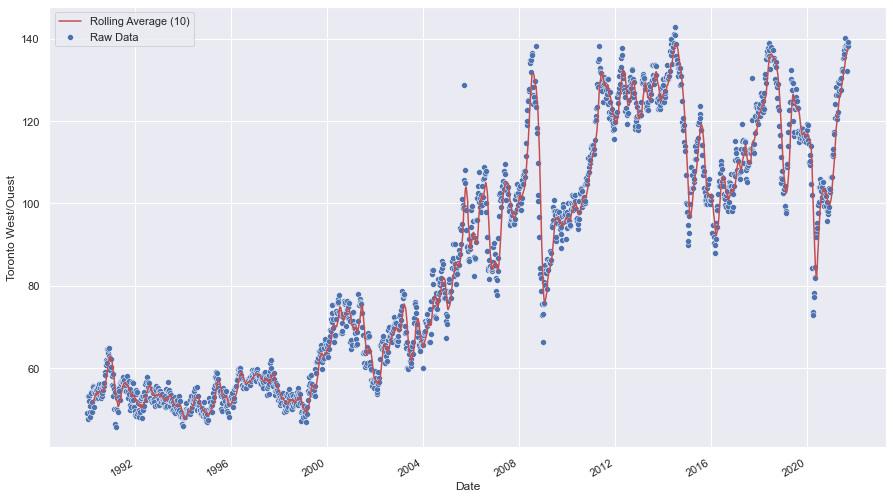

In [11]:
# take a look at the entire data along with window average
fig, ax = plt.subplots(figsize=(15,9))
sns.scatterplot(x=df['Date'], y=df['Toronto West/Ouest'], ax=ax, label='Raw Data')
rolling_width = 10
df.set_index('Date').rolling(rolling_width).mean()['Toronto West/Ouest'].plot(ax=ax, color='r', label=f'Rolling Average ({rolling_width})')
plt.legend()

# (S)ARIMA model
https://medium.com/analytics-vidhya/brent-oil-prices-forecast-with-prophet-and-arima-50f5f177da5b

In [18]:
train = df[(df['Date' ] > '2000-01-01') & (df['Date' ] <= '2019-12-31')]
test = df[df['Date' ] >= '2020-01-01']

## Let's gert value for `d`

In [20]:
#Convert to Time Series For ARIMA Estimator
series=pd.Series(data=train['Toronto West/Ouest'].to_numpy(), index=train['Date'])
series

Date
2000-01-05     63.4
2000-01-12     62.7
2000-01-19     65.9
2000-01-26     66.6
2000-02-02     64.7
              ...  
2019-12-02    115.7
2019-12-09    114.8
2019-12-16    116.3
2019-12-23    117.8
2019-12-30    119.3
Length: 1044, dtype: float64

In [21]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(series.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.296960
p-value: 0.172950


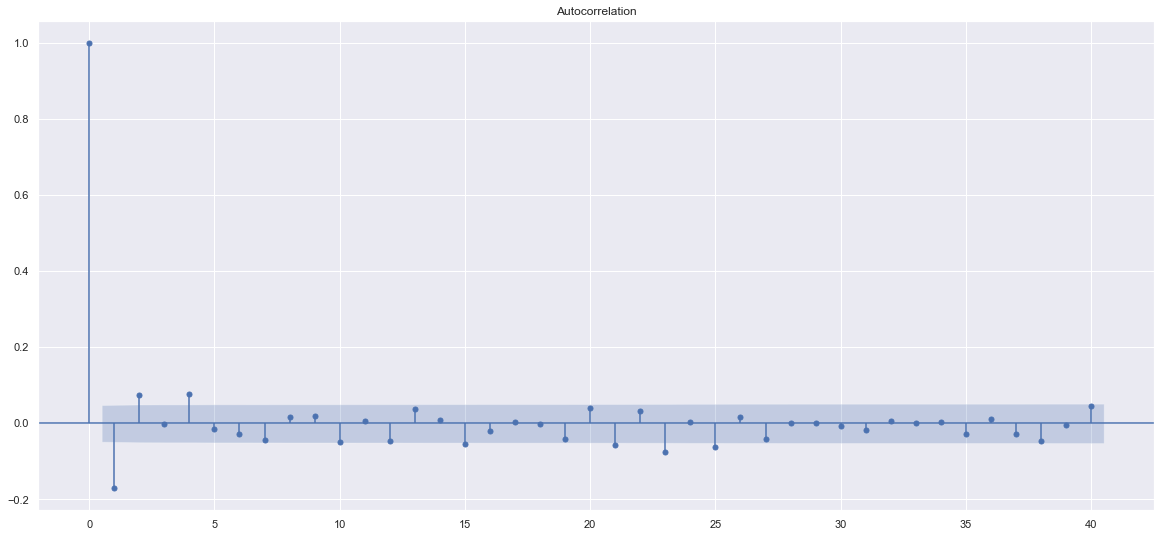

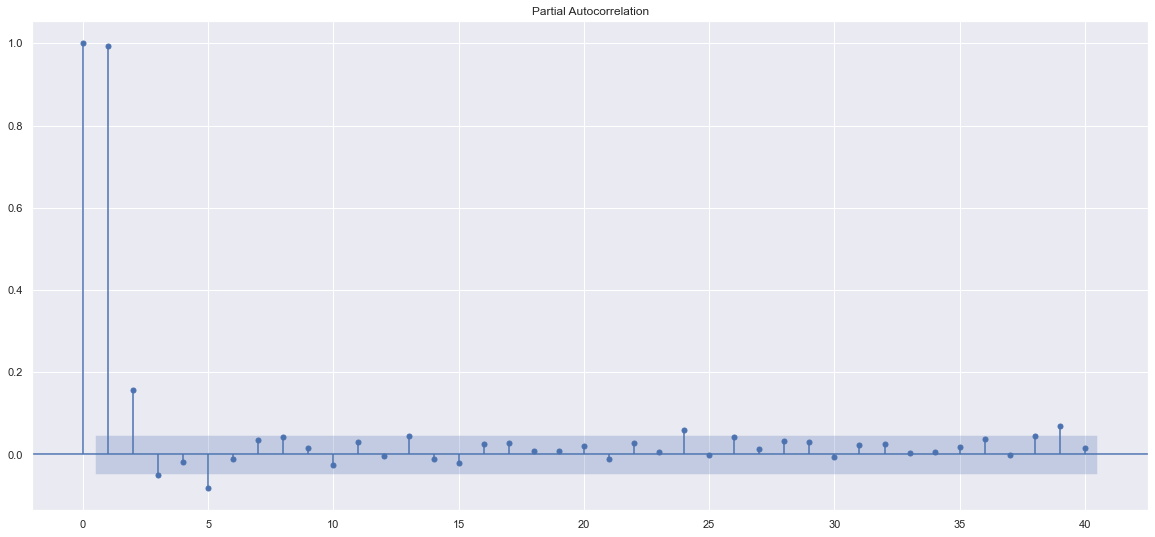

In [9]:
# plotting autocorrelation and partial autocorrelation 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(figsize=(20,9))
temp_df = df['Toronto West/Ouest']
plot_acf(   (temp_df - temp_df.shift())[1:], 
            lags=40, 
            ax=ax, 
            title='Autocorrelation'
        );
plt.show()
fig, ax = plt.subplots(figsize=(20,9))
plot_pacf(  temp_df, 
            lags=40,
            ax=ax, 
            title='Partial Autocorrelation'
        );
plt.show()

> seems like p=2 and q=2 should can be a good candidate for ARIMA model

In [13]:
# lets train an ARIMA model 
from statsmodels.tsa.arima_model import ARIMA

def backtest(test_data, model):
    """
    Using MSE to report performance
    
    test_data: [np.array]
    model : [trained ARIMA model]
    """
    predictions, _, _ = model.forecast(len(test_data))
    return np.mean(np.square(predictions - test_data))

def forecast_(data_F, TEST_SIZE=6, arima_order=(2,1,2)):
    '''
    INPUT:
    ------------------------------
    data_F      : [pandas.DataFrame]
                : N/A
    TEST_SIZE   : [int] [default = 6]
                : size of the test set
    arima_order : [touple of 3 int] [default = (2,1,2)]
                : order parameter for ARIMA model
    ------------------------------
    OUTPUT:
    ------------------------------
    trained ARIMA model
    
    '''
    df_train = data_F.iloc[:-TEST_SIZE]
    df_test = data_F.iloc[-TEST_SIZE:]

    model = ARIMA(df_train, order=arima_order)  
    res = model.fit(disp=-1) # disp just for viz

    fig, ax = plt.subplots(figsize=(20,9))
    ax.plot(data_F)

    res.plot_predict('2000', '2020', ax=ax);
    
    # evaluating performance
    mse = backtest(df_test.values, res)
    print('MSE: {}'.format(mse))
    
    return res, df_train, df_test, model

C:\Users\pui_s\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\pui_s\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date i

MSE: 6.580192514981704


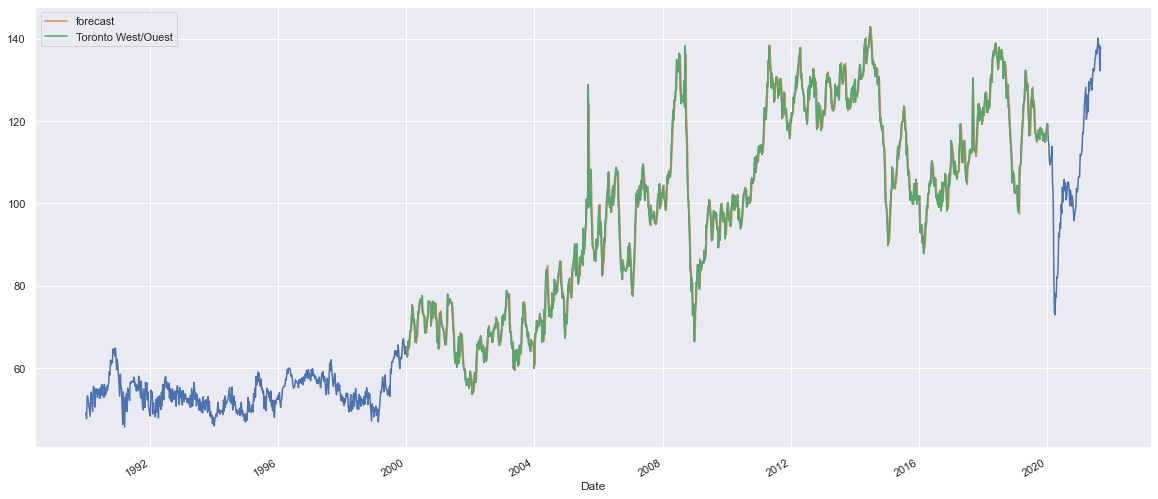

In [18]:
res, df_train, df_test, model = forecast_(data_F=df.set_index('Date')['Toronto West/Ouest'])

In [61]:
# Try yearly cyclical (52 weeks per year)
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
N_TEST = 52
df_train = df.set_index('Date')['Toronto West/Ouest'].iloc[:-N_TEST].copy()
model_sarimax = sm.tsa.statespace.SARIMAX(df_train, 
                                order=(2,1,2), 
                                seasonal_order=(2,1,2,52) # do not go crazy with the order number
                               )
res_sarimax = model_sarimax.fit(disp=False)
print(res_sarimax.summary())
fig, ax = plt.subplots()
ax.plot(df.set_index('Date')['Toronto West/Ouest'])

# forecast
pred_df = res_sarimax.predict(start=len(df_train), end=len(df_train)+51)
pred_df.index = df.Date.iloc[-52:]
ax.plot(pred_df);
# after trial-and-error, this set of p,d,q and P,D,Q 
# give the statistically significant model (based on P>|z|)

# and it fits nicely to the test data (the last 12 points from dataset)

C:\Users\pui_s\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\pui_s\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


# Ideas to try
take out inflation effect ??